# Cameroon: modelling and forecasting deforestation

- **Notebook address**: https://github.com/ghislainv/workshopReCaREDD/blob/master/deforCameroon/notebook/notebook.ipynb
- **GitHub repository for `deforestprob` Python module**: https://github.com/ghislainv/deforestprob
- **Author**: Ghislain Vieilledent https://ghislainv.github.io

This notebook will show you how to use the `deforestprob` Python module. The module can be used to estimate the spatial probability of deforestation in the tropics depending on various spatial environmental variables.

We first import the `deforestprob` module and the other necessary modules to run the script.

In [1]:
# Import modules
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import deforestprob as dfp
#%matplotlib inline

We also create a directory to hold the outputs with the help of the function `.make_dir()` from the `deforestprob` module.

In [2]:
# Make output directory
dfp.make_dir("output")

## Python preambule

Python is a widely-used programming language and is excellent for working with spatial data. For an introduction to Python, have a look at the [Python documentation](https://docs.python.org/2.7/). To see how you can use Python for Geoprocessing, I advice reading the book [_Geoprocessing with Python_](https://www.manning.com/books/geoprocessing-with-python?ref=gislounge.com) by [Chris Garrard](https://github.com/cgarrard).

If you want to see how to use a function in Python, simply write `help("function_name")` in the Python console. 

In [3]:
help(dfp.predict)

Help on function predict in module deforestprob.predict:

predict(model, var_dir='data', input_cell_raster='output/rho.tif', input_forest_raster='data/forest.tif', output_file='output/pred_binomial_iCAR.tif', blk_rows=128, figsize=(11.69, 8.27), dpi=200)
    Predict the spatial probability of deforestation from a model.
    
    This function predicts the spatial probability of deforestation
    from a model_binomial_iCAR model. Computation are done by block and
    can be performed on large geographical areas.
    
    :param model: model_binomial_iCAR model to predict from.
    :param var_dir: directory with rasters (.tif) of explicative variables.
    :param input_cell_raster: path to raster of rho values for spatial cells.
    :param input_forest_raster: path to forest raster (1 for forest).
    :param output_file: name of the raster file to output the probability map.
    :param blk_rows: if > 0, number of rows for computation by block.
    :param figsize: figure size in inches.
 

## Downloading and preparing the data

To model the spatial probability of deforestation, we need a map of the past deforestation and maps of potential explicative environmental variables. Environmental variables can be derived from _topography_ (altitude, slope, and aspect), _accessibility_ (distance to roads, towns, and forest edge), _deforestation history_ (distance to previous deforestation) or _landscape policy_ (location inside a protected area) for example. In our example, we use the following variables :

| Product                            | Source                  | Variable derived                   | Unit | Resolution (m) |
|------------------------------------|-------------------------|------------------------------------|:----:|---------------:|
| Deforestation maps (2000-**2005-2010**-2014) |  Hansen et al. 2013 (1)        | forest/non-forest                  |   -  |             30 |
|                                    |                         | distance to forest edge            |   m  |             30 |
|                                    |                         | distance to previous deforestation |   m  |             30 |
| Digital Elevation Model            | SRTM v4.1 CSI-CGIAR (2) | altitude                           |   m  |             90 |
|                                    |                         | slope                              |   °  |             90 |
|                                    |                         | aspect                             |   °  |             90 |
| Highways                           | OSM - Geofabrik (3)     | distance to road                  |   m  |            150 |
| Places                             |                         | distance to town                  |   m  |            150 |
| Waterways                          |                         | distance to river                  |   m  |            150 |
| Protected areas                    | Protected Planet UNEP-WCMC (4)             | presence of protected area         |   -  |             30 |

1. http://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.2.html, Hansen Global Forest Change v1.2 (2000-2014), Hansen et al. 2013
2. http://srtm.csi.cgiar.org, SRTM 90m Digital Elevation Database v4.1
3. http://www.geofabrik.de, data extracts from the OpenStreetMap project
4. http://www.protectedplanet.net, March 2007 version

To obtain the data, we can either (i) execute a bash script which downloads the raw data from the sources and computes the variables, or (ii) directly used the pre-computed variables that we copy to the data directory.

In [4]:
# =====================================
# Execute the bash script
# =====================================

# To execute the bash script, uncomment and run the following line
# os.system("sh scripts/data.sh")

In our example, `fcc05_10.tif` is a forest-cover change raster at 30m for the period 2005-2010. We can plot this raster and zoom on a region with function `.plot.forest()` in the `deforestprob` package to see the deforestation data. The remaining forest appears in green and the deforested areas appear in red.

Build overview


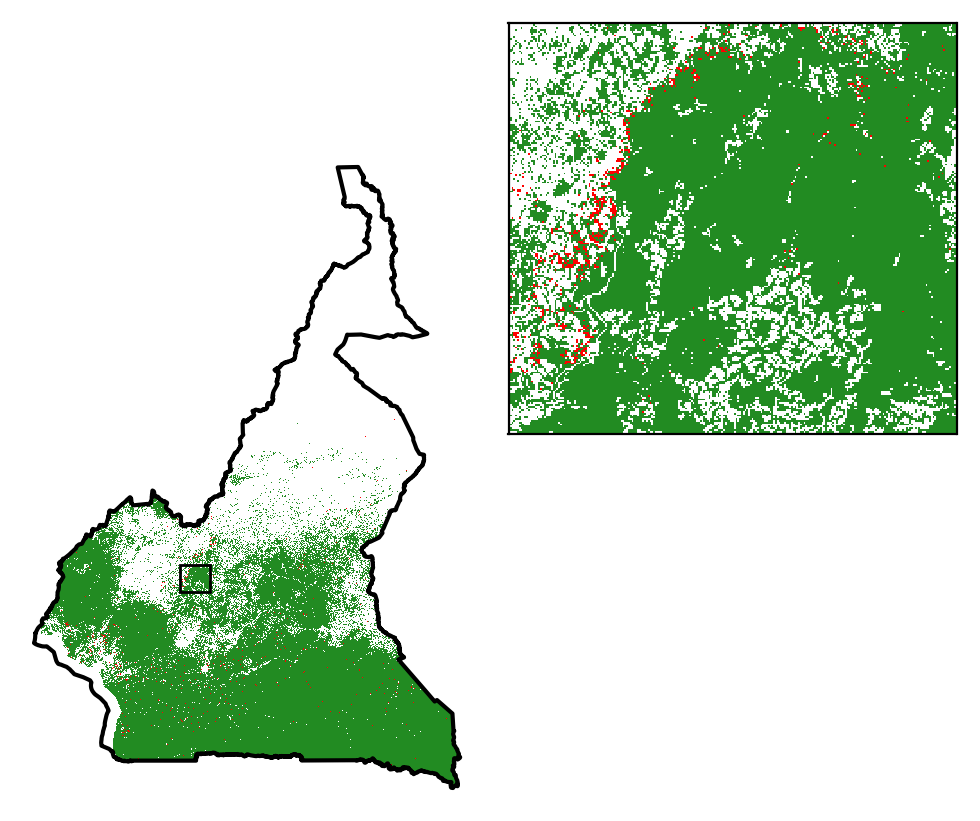

In [5]:
# ========================================================
# Plot forest
# ========================================================
forest_fig = dfp.plot.forest(input_forest_raster="data/fcc05_10.tif",
                output_file="output/forest.png",
                borders="data/borders_UTM.shp",
                col=(255, 0, 0, 255),  # rgba color for deforestation
                figsize=(5,5),
                dpi=200,
                zoom=(730000,790000,585000,640000))  # xmin, xmax, ymin, ymax
forest_fig

We can also plot the environmental raster files using function `.plot.var()` in the `deforestprob` package.

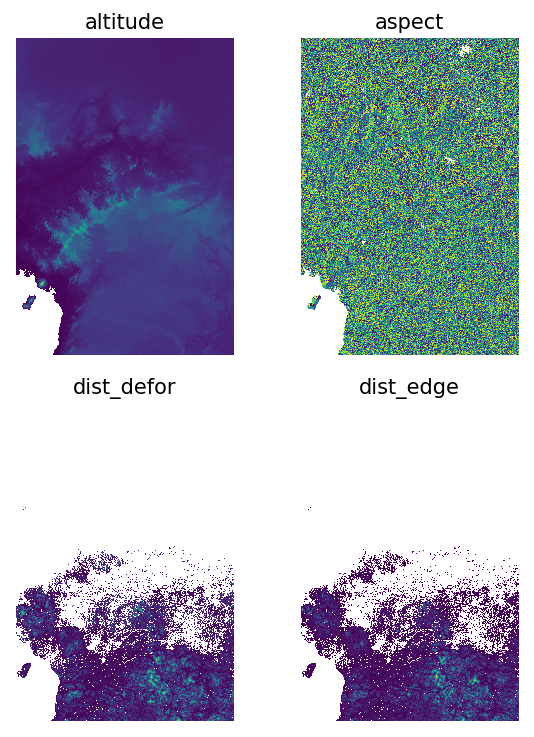

In [9]:
# ========================================================
# Plot environmental variables
# ========================================================
var_fig = dfp.plot.var(var_dir="data",
                       output_file="output/var.pdf",
                       gridsize=(2,2),
                       figsize=(5,6),
                       dpi=125)
var_fig[0]

## Sampling the observations

We use the function `.sample()` from the `deforestprob` module to sample 10,000 points (pixel centers) in the deforested areas and in the remaining forest (20,000 points in total). The `input_forest_raster` argument defines the path to the forest raster including the deforested pixels (with value=0) and the remaining forest pixels (value=1) after a given period of time. The random seed can be set with argument `Seed` to reproduce the data of the random sampling.

The `.sample()` function also extracts information from environmental variables for each sampled point. Sampling is done by block to allow the computation on large study areas (e.g. country or continental scale) with a fine spatial resolution (e.g. 30m). The `var_dir` argument indicates the directory including all the environmental raster files (they must be GeoTIFF files with extension `.tif`) that we want to test.

The `.sample()` function identifies the spatial cell for each sample point (sample point are grouped within a spatial cell). Spatial cells and grouped observations are used to estimate the spatial autocorrelation of the deforestation process. The `csize` argument define the width (in km) of the square spatial cells. Each spatial cell will be attributed a parameter. To avoid estimating too many parameters, width of the square spatial cells must be sufficiently large. Both points sampling and extraction of environmental data are done by block to avoid memory problems for big datasets.

In [11]:
# ========================================================
# Sample
# ========================================================

# Sample points
dataset = dfp.sample(nsamp=10000, Seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc05_10.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

Sample 2x10000 pixels (deforested vs. forest)
Divide region in 20880 blocks
Compute number of deforested and forest pixels per block
100%
Draw blocks at random
Draw pixels at random in blocks
100%
Compute center of pixel coordinates
Compute number of 10 x 10 km spatial cells
... 12328 cells (134 x 92)
Identify cell number from XY coordinates
Make virtual raster with variables as raster bands
Extract raster values for selected pixels
100%
Export results to file output/sample.txt


A [`pandas`](http://pandas.pydata.org/) `DataFrame` is returned by the function (each row being an observation) and the sampled observations are also written to a text file defined by the argument `output_file`.

In [12]:
# To import data as pandas DataFrame if necessary
dataset = pd.read_table("output/sample.txt",
                         delimiter=",")

# Print the first five rows
print(dataset.head(5))

   altitude  aspect  dist_defor  dist_edge  dist_river  dist_road  dist_town  \
0     315.0     0.0       408.0       30.0      6907.0     6900.0     7973.0   
1     166.0   270.0       510.0       30.0      1806.0     3245.0     1209.0   
2     230.0   325.0       960.0       30.0     15976.0     1831.0     1209.0   
3     533.0   172.0      1063.0       30.0     53960.0     4050.0     4149.0   
4     336.0   347.0        67.0       30.0      6366.0     1082.0      960.0   

   fcc05_10   pa  slope          X          Y    cell  
0       0.0  0.0    0.0  1150155.0  1196865.0  2834.0  
1       0.0  0.0    1.0   939105.0  1028595.0  4376.0  
2       0.0  0.0    2.0  1051065.0   996945.0  4664.0  
3       0.0  0.0    2.0  1154445.0   959325.0  5042.0  
4       0.0  0.0    1.0  1074015.0   937185.0  5218.0  


Sampled observations can be plotted using function `.plot.obs()` from the `deforestprob` module. Dark red dots indicate deforestation observations and dark green dots indicate forest observations. 

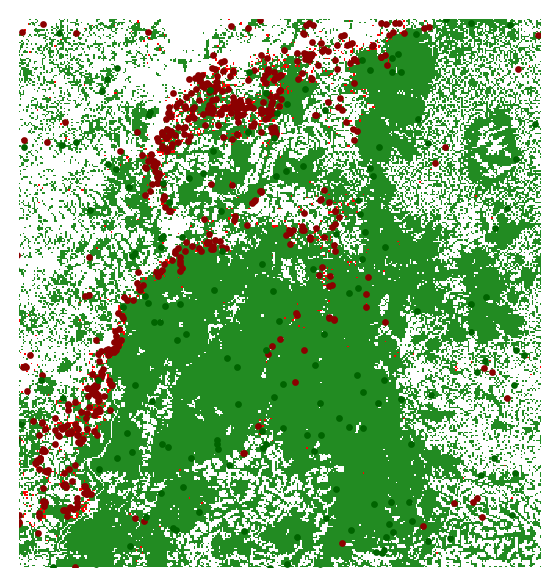

In [13]:
# Plot sample points
dfp.plot.obs(sample=dataset,
             name_forest_var="fcc05_10",
             input_forest_raster="data/fcc05_10.tif",
             output_file="output/obs.png",
             zoom=(730000,810000,587000,671000),  # xmin, xmax, ymin, ymax
             s=5,dpi=150)

## Descriptive statistics

Before modelling the deforestation, it is important to look at the relationship between environmental variables and deforestation. Using formulas from the [`patsy`](https://github.com/pydata/patsy) Python module, we can specify the relationships that we want to look at. In the example below, we plot the relationships between some continuous environmental variables and the probability of deforestation using function `.plot.correlation()` from the `deforestprob` package. Note that -1 must be set at the end of the formula. 

In [14]:
# ========================================================
# Descriptive statistics
# ========================================================

# To import data as pandas DataFrame if necessary
# dataset = pd.read_table("output/sample.txt",
#                         delimiter=",")

# Model formulas
formula_1 = "fcc05_10 ~ dist_road + dist_town + dist_defor + \
dist_river + dist_edge + altitude + slope + aspect - 1"
# Standardized variables (mean=0, std=1)
formula_2 = "fcc05_10 ~ scale(dist_road) + scale(dist_town) + \
scale(dist_defor) + scale(dist_river) + scale(dist_edge) + \
scale(altitude) + scale(slope) + scale(aspect) - 1"
formulas = (formula_1, formula_2)

# List to store figures
corr_fig = []

# Remove NA from data-set (otherwise scale() doesn't work)
dataset = dataset.dropna(axis=0)

# Loop on formulas
for f in range(len(formulas)):
    # Output file
    of = "output/correlation_" + str(f) + ".pdf"
    # Data
    y, data = dmatrices(formulas[f], data=dataset,
                        return_type="dataframe")
    
    # Plots
    corr_fig.append(dfp.plot.correlation(y=y, data=data, 
                                         plots_per_page=3,
                                         figsize=(7,8),
                                         dpi=100,
                                         output_file=of))

The function `.correlation()` returns a serie of graphics that can be analyzed to choose the right relationship for each continuous variable (linear or polynomial for example).

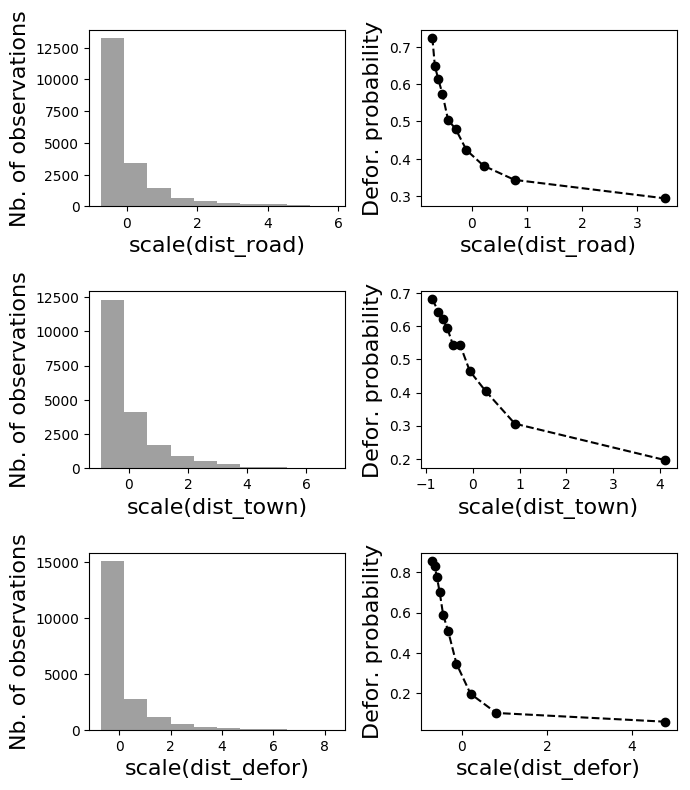

In [15]:
# Correlation plots
corr_fig[1][0]

In this example, we can see that a linear model should be sufficient to represent the relationship between the probability of deforestation and the standardized distance to the nearest road or town. On the contrary, it could be interesting to fit a polynomial model for the the standardized distance to previous deforestation (`dist_defor` variable) for which the relationship seems non-linear. Several models can be fitted and compared to see if a second-order or third-order polynomial relationship is justified.

## Spatial deforestation model

We propose to use the **Binomial iCAR** model ([Vieilledent et al. 2014](http://doi.org/10.5281/zenodo.48470)) to estimate the deforestation probability of a pixel given a set of environmental variables. The Binomial iCAR model is a linear Binomial logistic regression model including an intrinsic Conditional Autoregressive (iCAR) process to account for the spatial autocorrelation of the observations. Parameter inference is done in a hierarchical Bayesian framework. The `.model_binomial_iCAR()` function from the `deforestprob` module includes a Metropolis-within-Gibbs algorithm written in pure C code to reduce computation time.

![Bayes](images/Bayes.jpg)
**Figure caption:** Parameter inference is done in a hierarchical Bayesian framework, which relies on the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes'_theorem) named after [Reverend Thomas Bayes](https://en.wikipedia.org/wiki/Thomas_Bayes). Each parameter has a prior and an approximated posterior probability distribution from which we can compute the mean, standard deviation, credible intervals at 95%, etc.

For the deforestation process it is _**very important to take into account the spatial autocorrelation of the process**_ with spatial random effects. Indeed, the selected fixed environmental variables are not able to fully explain the spatial variability of the deforestation process, especially when working at large geographical scales, such as the national or continental scale. Spatial random effects allow estimating a higher/lower probability of deforestation in a particular region (associated to unmeasurable or unknow factors) that is different from the mean probability of deforestation derived from the environmental factors included in the model. The Binomial iCAR model can be discribed as follow:

** Ecological process **

\begin{equation}
y_i \sim \mathcal{B}inomial(\theta_i,t_i) \\
\text{logit}(\theta_i) = X_i \beta + \rho_{j(i)}
\end{equation}

$y_i$: random variable for the deforestation process (0 if no deforestation, 1 if deforestation)

$\theta_i$: probability of deforestation

$t_i$: number of trials (always 1 in our example)

$X_i$: vector of values for environmental explicative variables

$\beta$: vector of fixed effect parameters

$\rho_j$: spatial random effect
  
$j(i)$: index of the spatial entity for observation $i$.
  
** Spatial autocorrelation **
  
The spatial autocorrelation is modelled with an intrinsic conditional autoregressive (iCAR) process:

\begin{equation}
\rho_j \sim \mathcal{N}ormal(\mu_j,V_{\rho} / n_j)
\end{equation}

$\mu_j$: mean of $\rho_{j'}$ in the neighborhood of $j$.
  
$V_{\rho}$: variance of the spatial random effects.
  
$n_j$: number of neighbors for spatial entity $j$.

![iCAR process](images/iCAR.png)
**Figure caption:** Representation of the neighborhood for the intrinsic conditional autoregressive (iCAR) process. Target spatial cell $j$ has 8 neighbors in this case. Several observations (black points, equivalent to pixel centers in our case) can be located in each spatial cell. Deforestation probability in one spatial cell $j$ depends on deforestation probability in neighboring cells.

Before running the model, we add a column indicating the number of trials for each observation (1 in our case as we are considering a Bernoulli process). We then remove any observation with non-available data (NA) from the data-set. We also compute the number of neighbors (`nneigh`) and the neighbor identifiers (`adj`) for each spatial cell using function `.cellneigh` from the `deforestprob` module.

A model formula must also be defined to specify the explicative variables we want to include in the model. The formula allows specifying some variable transformations (such as standardization in our case). See the [`patsy`](https://patsy.readthedocs.io/en/latest/) module for more information. In our model, we included the following variables: location inside a protected area, altitude, distance to past deforestation (with a degree two polynomial), distance to forest edge, distance to nearest road and distance to nearest town. The formula must end with the name of the variable indicating the spatial cell for each observation (`cell` in our case).

In [17]:
# ========================================================
# hSDM model
# ========================================================

# Set number of trials to one
dataset["trial"] = 1

# Remove observations with NA
dataset = dataset.dropna(axis=0)

# Spatial cells for spatial-autocorrelation
nneigh, adj = dfp.cellneigh(raster="data/fcc05_10.tif", csize=10, rank=1)

# Formula
formula = "I(1-fcc05_10) + trial ~ C(pa) + scale(altitude) +  scale(slope) + \
scale(dist_defor) + np.power(scale(dist_defor),2) + \
scale(dist_edge) + \
scale(dist_road) + scale(dist_town) + cell"

Compute number of 10 x 10 km spatial cells
... 12328 cells (134 x 92)
Identify adjacent cells and compute number of neighbors


In [18]:
# Model
mod_binomial_iCAR = dfp.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Chains
    burnin=1000, mcmc=1000, thin=1,
    # Starting values
    beta_start=-99)

Using estimates from classic logistic regression as starting values for betas


## Results of the model

Once the model has been fitted, we can print a summary of the model showing the parameter estimates. The 95% credible intervals obtained from the posterior distribution of each parameter, except distance to nearest town (`dist_town`), do not include zero, indicating that parameters are significantly different from zero. The variance of the spatial random effects (`Vrho`) is given together with the deviance value, which can be used to compare different statistical models (lower deviance is better). Looking at the parameter estimates, we can see that the deforestation probability is much lower inside protected areas and that deforestation probability decreases with altitude, slope, distance to past deforestation, forest edge, roads and towns. Parameter values are then coherent regarding the deforestation process and easy to interpret.

In [20]:
# Summary
estimates_file = open("output/estimates.txt", "w")
print >> estimates_file, mod_binomial_iCAR
estimates_file.close()
print(mod_binomial_iCAR)

Binomial logistic regression with iCAR process
  Model: I(1 - fcc05_10) + trial ~ 1 + C(pa) + scale(altitude) + scale(slope) + scale(dist_defor) + np.power(scale(dist_defor), 2) + scale(dist_edge) + scale(dist_road) + scale(dist_town) + cell
  Posteriors:
                                     Mean        Std     CI_low    CI_high
                     Intercept      -0.14     0.0904      -0.32     0.0196
                  C(pa)[T.1.0]     -0.919      0.169      -1.26     -0.644
               scale(altitude)     0.0944     0.0568    -0.0183       0.18
                  scale(slope)     -0.159     0.0245     -0.202     -0.115
             scale(dist_defor)      -1.93     0.0726      -2.05       -1.8
np.power(scale(dist_defor), 2)      0.373      0.016      0.336      0.402
              scale(dist_edge)     -0.714     0.0811     -0.886     -0.547
              scale(dist_road)     -0.221     0.0747     -0.383     -0.075
              scale(dist_town)     -0.152     0.0424     -0.228    -0

To check for the convergence of the Markov chain Monte Carlo (MCMC), we can plot the traces and the posterior distributions of the estimated parameters using method `.plot()` associated to the `hSDM_binomial_iCAR` class defined in the `deforestprob` module. This method returns the figures showing the traces and posterior distributions.

Traces and posteriors will be plotted in output/mcmc.pdf


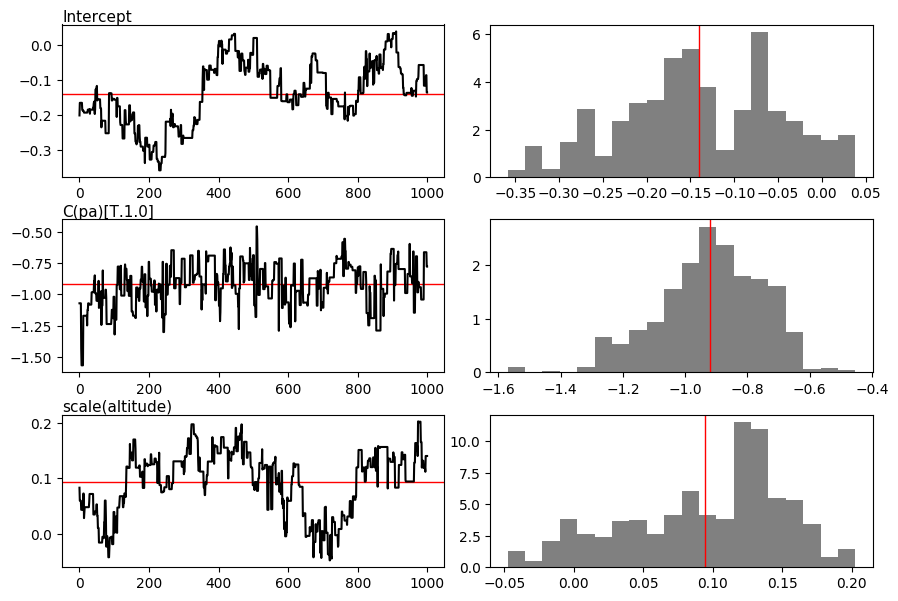

In [21]:
# Plot
traces_fig = mod_binomial_iCAR.plot(output_file="output/mcmc.pdf",
                                    plots_per_page=3,
                                    figsize=(9,6),
                                    dpi=100)
traces_fig[0]

## Predicting the spatial probability of deforestation

We use the model to predict the spatial probability of deforestation at the national scale for Madagascar. Before, doing so, we smooth the spatial random effects which have been estimated at a coarse resolution (10km in our example). To do so, we use the function `.resample_rho()` from the `deforestprob` module to resample the results at a finer resolution using a bilinear interpolation. The function writes a raster file to the disk with a resolution of the raster specified in the argument `input_raster` of the function (1km in our case). The function `.resample_rho()` returns a figure of the spatial random effects that can be plotted.

Write spatial random effect data to disk
Compute statistics
Build overview
Resampling spatial random effects to file output/rho.tif
Make figure


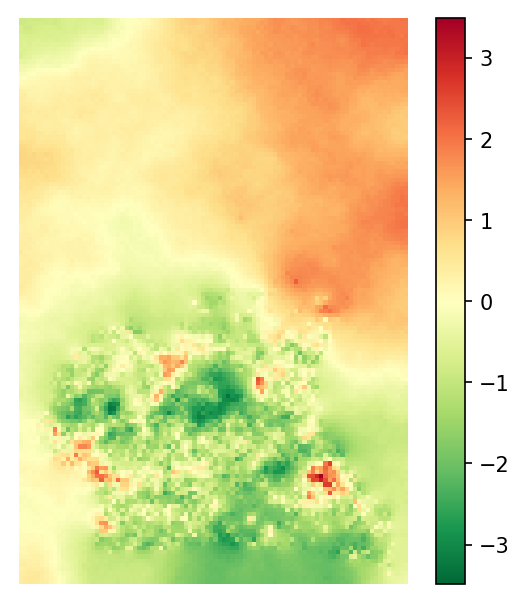

In [22]:
# ========================================================
# Resampling spatial random effects
# ========================================================

# Spatial random effects
rho = mod_binomial_iCAR.rho

# Resample
dfp.resample_rho(rho=rho, input_raster="data/fcc05_10.tif",
                 output_file="output/rho.tif",
                 csize_orig=10, csize_new=1,
                 figsize=(5,5),
                 dpi=150)

The `.predict_hSDM()` function of the `deforestprob` module can be used to predict the spatial probability of deforestation from an **hSDM_binomial_iCAR** model (i.e. an object of class `hSDM_binomial_iCAR`). The function writes a raster of predictions to the disk and returns a figure with the predictions that can be plotted. The prediction is done by block to avoid memory problems for big datasets. Functions will return NA for pixels with no forest or for pixels with missing environmental variables.

In [23]:
# ========================================================
# Predicting spatial probability of deforestation
# ========================================================

# Compute predictions
fig_pred = dfp.predict(mod_binomial_iCAR, var_dir="data",
            input_cell_raster="output/rho.tif",
            input_forest_raster="data/fcc05_10.tif",
            output_file="output/pred_binomial_iCAR.tif",
            blk_rows=128,
            dpi=200)

Make virtual raster with variables as raster bands
Divide region in 348 blocks
Create a raster file on disk for projections
Predict deforestation probability by block
100%
Compute statistics
Build overview
Make figure


We can then plot the spatial probability of deforestation.

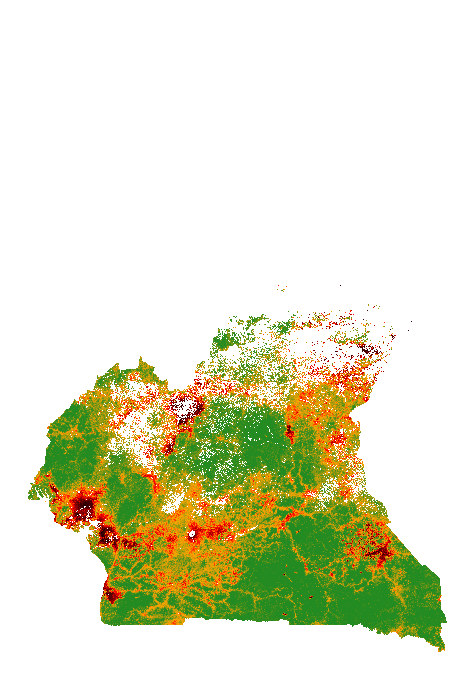

In [24]:
# Plot the spatial probability of deforestation.
fig_pred.set_size_inches(10,12)
fig_pred

## Predicting the future forest cover

Given the spatial probability of deforestation and the number of hectares that should be deforested, we can predict the future forest cover using function `.deforest()` from the `deforestprob` package. The number of hectares are converted into number of pixels to be deforested. The function computes a probability threshold above which pixels are deforested. Pixels with the highest probability of deforestation are deforested first. 

Using [GlobalForestWatch](http://www.globalforestwatch.org/country/CMR) data and a tree cover threshold of 50%, we estimate an historical annual deforestation rate of roughly 41,000 ha for Cameroon on the period 2001-2014. Considering 40 years on the period 2010-2050, this would correspond to 1.64 Mha of deforestation. This number can of course be more precise and refined considering various historical periods and deforestation scenarios (demographic growth, economic development, etc.).

Divide region in 348 blocks
Compute the total number of forest pixels
100%
Compute the histogram of values
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest cover
Write raster of forest cover
100%
Compute statistics
Build overview
Make figure


TypeError: super(type, obj): obj must be an instance or subtype of type

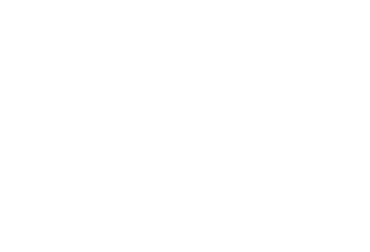

In [51]:
# ========================================================
# Predicting forest cover
# ========================================================

forest_cover = dfp.deforest(input_raster="output/pred_binomial_iCAR.tif",
                            hectares=1640000,
                            output_file="output/forest_cover_2050.tif",
                            blk_rows=128)

Because deforestation probability is scaled on the interval [1, 65535] including 65535 values, there might be a difference between the deforested hectares set as input and the true deforested surfaces. The magnitude of the difference depends on the distribution of the deforestation probabilities. Usually, the distribution of the deforestation probabilities should be asymmetric with low frequencies for higher probabilities of deforestation.

In [52]:
# Distribution of the deforestation probabilities
frequences = forest_cover["statistics"][0]
threshold = forest_cover["statistics"][1]
freq = plt.figure()
plt.subplot(111)
plt.plot(frequences, "bo")
plt.title("Frequencies of deforestation probabilities")
plt.axvline(x=threshold, color='k', linestyle='--')
freq

NameError: name 'forest_cover' is not defined

As a consequence, the error should be negligible compared to the number of hectares set as input.

In [ ]:
# Error regarding deforested hectares
future_forest_error = forest_cover["statistics"][2]
future_forest_hectares = forest_cover["statistics"][3]
error_perc = 100*future_forest_error/future_forest_hectares
print("Error (ha): %.2f, %.3f%%" % (future_forest_error, error_perc))

We can plot the predicted future forest cover in 2050. The purple areas represent the deforestation on the period 2010-2050. The green areas represent the remaining forest in 2050. Most of the remaining forest in 2050 are inside the protected areas or located in remote areas, at high altitudes and far from roads and big cities (for example in the Tsaratanana mountain region and around the Masoala peninsula, north-east Madagascar).

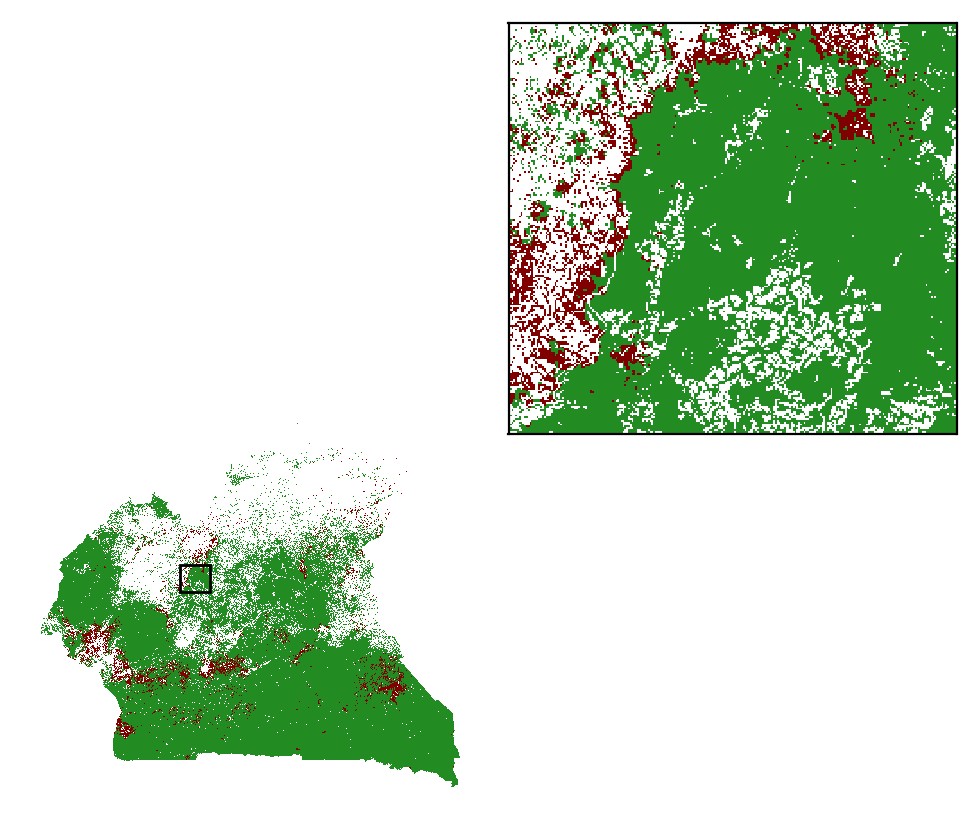

In [5]:
# Plot future forest cover
dfp.plot.forest(input_forest_raster="output/forest_cover_2050.tif",
                output_file="output/forest_cover_2050.png",
                col=(128, 0, 0, 255),  # rgba color for deforestation
                figsize=(5,5),
                dpi=200,
                zoom=(730000,790000,585000,640000))  # xmin, xmax, ymin, ymax

## Carbon emissions

Carbon emissions associated to future deforestation can be computed using function `.emissions()` in the `deforestprob` package in combination with an aboveground forest biomass map. For example, we can use the pantropical 1km aboveground biomass map of Avitabile et al. (2016).

In [25]:
carbon = dfp.emissions(input_stocks="data/emissions/AGB.tif",
                       input_forest="output/forest_cover_2050.tif",
                       coefficient=0.47,
                       blk_rows=128)

Make virtual raster
Divide region in 348 blocks
Compute carbon emissions by block
100%


In [29]:
print("Carbon emissions associated to future deforestation: %d Mg" % (carbon))

Carbon emissions associated to future deforestation: 151548020 Mg


## Model validation

### Deviance explained

We can compute the percentage of deviance explained by the model with or without accounting for spatial autocorrelation. To do so, we need to compute the [deviance of the full (or saturated) and null model](http://www.stat.wisc.edu/courses/st849-bates/lectures/GLMDeviance.pdf). The full model assumes a perfect fit of the data and has a deviance equals to zero. The null model is a simple mean-only model ($\text{logit}(\theta_i)=\mu$). The deviance of the null model and of the model without spatial autocorrelation can be computed using a classical Binomial regression, without hierarchical structure. We will use the `statsmodels` Python module to do so.

In [19]:
# Additional module
import statsmodels.api as sm
# Full model
deviance_full = 0
# Null model
formula_null = "I(1-fcc05_10) ~ 1"
Y, X = dmatrices(formula_null, data=dataset, NA_action="drop", return_type="dataframe")
mod_null = sm.GLM(Y, X, family = sm.families.Binomial())
fit_null = mod_null.fit()
deviance_null = fit_null.deviance
# Model with no spatial random effects
formula_nsre = "I(1-fcc05_10) ~ C(pa) + scale(altitude) +  scale(slope) + \
scale(dist_defor) + np.power(scale(dist_defor),2) + scale(dist_edge) + scale(dist_road) + scale(dist_town)"
Y, X = dmatrices(formula_nsre, data=dataset, NA_action="drop", return_type="dataframe")
mod_nsre = sm.GLM(Y, X, family = sm.families.Binomial())
fit_nsre = mod_nsre.fit()
deviance_nsre = fit_nsre.deviance
# Model with iCAR process
deviance_icar = mod_binomial_iCAR.Deviance
# Dataframe
mod = np.array(["null", "nsre", "icar", "full"])
dev = np.array([deviance_null, deviance_nsre, deviance_icar, deviance_full])
perc = 100*(1-dev/deviance_null)
print(pd.DataFrame.from_items([("model", mod),
                               ("deviance", np.rint(dev).astype(int)),
                               ("percentage", np.rint(perc).astype(int))]))

  model  deviance  percentage
0  null     27697           0
1  nsre     19860          28
2  icar     16418          41
3  full         0         100


We see that the model without spatial random effects explains 28% of the deviance while the model including spatial random effects explains 41% of the deviance. These percentage might appear rather low, but one should remember that we are trying to predict the deforestation at the pixel scale with a precision of 30 meters.

### Predictions vs. observations

Another way of assessing model performance is to compute some accuracy indices based on a confusion matrix. We select the following accuracy indices: the Overall Accuracy (OA), the Specificity (Spe), the Sensitivity (Sen), Cohen's Kappa (K), the True Skill Statistics (TSS) and the Figure Of Merit (FOM). These indices are classical indices used to estimate the accuracy of deforestation models (see for example Dezécache et al. 2017, Vieilledent et al. 2013 and Pontius et al. 2011).

#### Internal validation

We first compute these indices on the sampling data-set. Here we are interested in seeing if our model is predicting well the location of the deforestation (relative deforestation probability), not the intensity of deforestation (absolute deforestation probability). We then transform the predicted probability of deforestation into binary values using the deforestation probability "observed" in the sampling data-set. This last value should be closed to 0.5 as we sampled as many forest and non-forest pixels, at the exception of the pixels with no-data value for environmental variables. The same proportion of deforested pixels will be applied to the predictions selecting the pixels with the highest predicted deforestation probabilities.

In [55]:
# Predictions
dataset["pred"] = 0
dataset["theta_pred"] = mod_binomial_iCAR.theta_pred
# Proportion of deforested pixels
nobs = dataset["fcc05_10_ctry"].size  # inferior to 20000 as there were NaN
ndefor = sum(dataset["fcc05_10_ctry"] == 0)  # 0 for deforestation in fordefor2010
proba_defor = float(ndefor)/nobs  # not exactly 0.5
# Probability threshold to transform probability into binary values
proba_thresh = np.percentile(dataset["theta_pred"], 100*(1-proba_defor))  # ! must be (1-proba_defor)
dataset.loc[dataset["theta_pred"] >= proba_thresh, "pred"] = 1
# We check that the proportion of deforested pixel is the same for observations/predictions
ndefor_pred = sum(dataset["pred"] == 1)
proba_defor_pred = float(ndefor_pred)/nobs
proba_defor_pred == proba_defor

True

We use function `accuracy_indices()` from the `deforestprob` package to compute the accuracy indices. 

In [56]:
# Accuracy indices
pred = dataset["pred"].tolist()
obs = (1-dataset["fcc05_10_ctry"]).tolist()
internal_validation = dfp.accuracy_indices(pred,obs)
print(internal_validation)

{'K': 0.66, 'OA': 0.83, 'Spe': 0.83, 'Sen': 0.83, 'FOM': 0.71, 'TSS': 0.66}


The accuracy indices show that the model has good predictive abilities. Their value is relatively high (close to 1). Once we know the number of pixels to be deforested, the model correctly identifies the pixels that should be deforested first.  

## Conclusion

### Prolongement de l'étude

- Calcul des émissions de carbone en couplant carte de déforestation et carte de carbone
- Validation du modèle avec changement de couverture forestière sur la période 2010-2014

### Améliorations possibles

- Source pour la carte de déforestation historique (Hansen, Facet, Roadless)
- Ajouter de nouvelles variables explicatives
- Raffiner le modèle de probabilité avec des fonctions polynomes
- Multiplier les scénarios concernant l'intensité de la déforestation future: tendance moyenne, scénarios extrêmes.

## References

** Avitabile, V., Herold, M., Heuvelink, G. B. M., Lewis, S. L., Phillips, O. L., Asner, G. P., Armston, J., Ashton, P. S., Banin, L., Bayol, N., Berry, N. J., Boeckx, P., de Jong, B. H. J., DeVries, B., Girardin, C. A. J., Kearsley, E., Lindsell, J. A., Lopez-Gonzalez, G., Lucas, R., Malhi, Y., Morel, A., Mitchard, E. T. A., Nagy, L., Qie, L., Quinones, M. J., Ryan, C. M., Ferry, S. J. W., Sunderland, T., Laurin, G. V., Gatti, R. C., Valentini, R., Verbeeck, H., Wijaya, A. and Willcock, S.** 2016. An integrated pan-tropical biomass map using multiple reference datasets. _Global Change Biology_. 22: 1406–1420.
doi: [10.1111/gcb.13139](http://doi.org/10.1111/gcb.13139)

**Dezécache, C.; Salles, J.-M.; Vieilledent, G. & Hérault, B.** 2017. Moving forward socio-economically focused models of deforestation. _Global Change Biology_. in press.
doi: [10.1111/gcb.13611](http://doi.org/10.1111/gcb.13611)

**Hansen, M. C.; Potapov, P. V.; Moore, R.; Hancher, M.; Turubanova, S. A.; Tyukavina, A.; Thau, D.; Stehman, S. V.; Goetz, S. J.; Loveland, T. R.; Kommareddy, A.; Egorov, A.; Chini, L.; Justice, C. O. & Townshend, J. R. G.** 2013. High-Resolution Global Maps of 21st-Century Forest Cover Change. _Science_. 342:850-853.
doi: [10.1126/science.1244693](http://doi.org/10.1126/science.1244693)

**Pontius R. G. Jr., J. & Millones, M.** 2011. Death to Kappa: birth of quantity disagreement and allocation disagreement for accuracy assessment. _International Journal of Remote Sensing_. 32:4407-4429.
doi: [10.1080/01431161.2011.552923](http://doi.org/10.1080/01431161.2011.552923)

**Vieilledent, G.; Merow, C.; Guélat, J.; Latimer, A. M.; Kéry, M.; Gelfand, A. E.; Wilson, A. M.; Mortier, F. & Silander Jr., J. A.** 2014. hSDM CRAN release v1.4 for hierarchical Bayesian species distribution models. _Zenodo_.
doi: [10.5281/zenodo.48470](http://doi.org/10.5281/zenodo.48470)

**Vieilledent, G.; Grinand, C. & Vaudry, R.** 2013. Forecasting deforestation and carbon emissions in tropical developing countries facing demographic expansion: a case study in Madagascar. _Ecology and Evolution_. 3:1702-1716.
doi: [10.1002/ece3.550](http://doi.org/10.1002/ece3.550)